In [ ]:
from __future__ import print_function
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from six.moves import urllib

torch.manual_seed(0)
plt.ion()  

In [2]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

full_dataset = torchvision.datasets.ImageFolder(root = '/data/siddhant/MedicalSTN/DrVineetData/Knee_AP', 
                                     transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Grayscale(num_output_channels=3),
                       transforms.Resize((512,512)),
                   ]))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, shuffle=True, num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, shuffle=True, num_workers=2)

In [3]:
full_dataset.find_classes('/data/siddhant/MedicalSTN/DrVineetData/Knee_AP')

(['LEGION', 'LPS', 'NRG', 'OPTERAK LOGIC', 'PERSONA'],
 {'LEGION': 0, 'LPS': 1, 'NRG': 2, 'OPTERAK LOGIC': 3, 'PERSONA': 4})

In [4]:
class STNresnet(nn.Module):
    def __init__(self):
        super(STNresnet, self).__init__()
        # Spatial transformer localization-network
        self.finalfc = nn.Linear(1000, 10)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        self.resnetportion = torchvision.models.resnet18(pretrained = False)
    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        x = self.resnetportion(x)
        x = self.finalfc(x)
        return F.log_softmax(x, dim=1)


In [5]:
class STNnet(nn.Module):
    def __init__(self):
        super(STNnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20 * 125 * 125, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [11]:
# model = STNnet().to(device)
# model = STNresnet().to(device)
model = torch.load('/home/siddhant/data/MedicalSTN/models/stnresnetv2/model.pt')

In [12]:
def train(epoch):
    model.train()
    for data, target in tqdm(train_loader): 
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         if batch_idx % 5 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
    

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        preds = []
        targets = []
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(np.array(pred.cpu()))
            targets.extend(np.array(target.cpu()))
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(targets, preds)
        print(conf_mat)
        #TODO make confusion matrix
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

def train_conf():
    with torch.no_grad():
        model.eval()
        train_loss = 0
        correct = 0
        preds = []
        targets = []
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            train_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(np.array(pred.cpu()))
            targets.extend(np.array(target.cpu()))
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(targets, preds)
        print(conf_mat)
        train_loss /= len(train_loader.dataset)
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(train_loss, correct, len(train_loader.dataset),
                      100. * correct / len(train_loader.dataset)))

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [17]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)

        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    #TODO make confusion matrix
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))
with torch.no_grad():
    model.eval()
    train_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        train_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(train_loss, correct, len(train_loader.dataset),
                  100. * correct / len(train_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))

  0%|          | 0/2 [00:00<?, ?it/s]


Test set: Average loss: 0.4570, Accuracy: 117/128 (91%)

25 26
16 20
14 14
31 31
31 37


  0%|          | 0/8 [00:00<?, ?it/s]


Train set: Average loss: 0.0002, Accuracy: 512/512 (100%)

77 77
80 80
87 87
136 136
132 132


torch.Size([64, 3, 512, 512]) torch.Size([64, 3, 512, 512]) tensor(0.9999) tensor(0.9999)


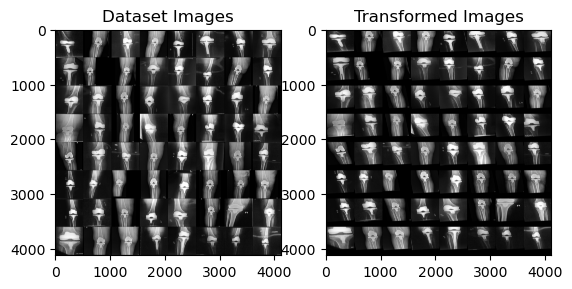

In [18]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        print(input_tensor.shape, transformed_input_tensor.shape, max(input_tensor.flatten()), max(transformed_input_tensor.flatten()))
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

visualize_stn()

In [13]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        print(input_tensor.shape, transformed_input_tensor.shape, max(input_tensor.flatten()), max(transformed_input_tensor.flatten()))
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 500 + 1):
    train(epoch)
    train_conf()
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[35  0 42  0  0]
 [20  0 60  0  0]
 [12  0 75  0  0]
 [43  0 48 45  0]
 [61  0 39 31  1]]

Train set: Average loss: 9.9102, Accuracy: 156/512 (30%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[12  0 14  0  0]
 [ 7  0 13  0  0]
 [ 4  0 10  0  0]
 [ 5  0 13 13  0]
 [22  0  4 10  1]]

Test set: Average loss: 9.4993, Accuracy: 36/128 (28%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0   0   0   0  77]
 [  0   0   0   0  80]
 [ 30   1   1   0  55]
 [  2   0   0   0 134]
 [  0   0   0   0 132]]

Train set: Average loss: 11.1506, Accuracy: 133/512 (26%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  0  0  0 26]
 [ 0  0  0  0 20]
 [ 2  0  1  0 11]
 [ 0  0  0  0 31]
 [ 0  0  0  0 37]]

Test set: Average loss: 10.0669, Accuracy: 38/128 (30%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0 75  0  1]
 [28  0 51  0  1]
 [ 0  0 87  0  0]
 [ 0  0 65 70  1]
 [15  1 61 15 40]]

Train set: Average loss: 5.8659, Accuracy: 198/512 (39%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  0 26  0  0]
 [ 7  2 10  0  1]
 [ 0  0 14  0  0]
 [ 0  0 12 19  0]
 [ 4  0 17  9  7]]

Test set: Average loss: 6.7244, Accuracy: 42/128 (33%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 9 38 28  0  2]
 [ 1 77  2  0  0]
 [ 8  6 73  0  0]
 [ 4  0 56 60 16]
 [12 32 46  5 37]]

Train set: Average loss: 3.2947, Accuracy: 256/512 (50%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1 16  9  0  0]
 [ 0 20  0  0  0]
 [ 3  0 11  0  0]
 [ 0  0 10 17  4]
 [ 2  5 16  3 11]]

Test set: Average loss: 4.5486, Accuracy: 60/128 (47%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0   1   0   1  75]
 [  0  27   0   0  53]
 [  1   3   0   0  83]
 [  0   0   0  18 118]
 [  0   3   0   4 125]]

Train set: Average loss: 3.3943, Accuracy: 170/512 (33%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  1  0  0 25]
 [ 0  6  0  0 14]
 [ 0  0  0  0 14]
 [ 0  0  0  3 28]
 [ 0  0  0  1 36]]

Test set: Average loss: 3.1280, Accuracy: 45/128 (35%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  1   0   0  75   1]
 [  7   0   0   3  70]
 [  0   0  11  76   0]
 [  0   0   0 136   0]
 [  0   0   0  75  57]]

Train set: Average loss: 2.8801, Accuracy: 205/512 (40%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0  0 24  1]
 [ 1  0  0  1 18]
 [ 0  0  2 12  0]
 [ 0  0  0 31  0]
 [ 0  0  0 28  9]]

Test set: Average loss: 3.1293, Accuracy: 43/128 (34%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  1   0  70   6   0]
 [ 46   4  29   1   0]
 [  0   0  87   0   0]
 [  0   0   0 135   1]
 [ 27   0  36  55  14]]

Train set: Average loss: 3.0410, Accuracy: 241/512 (47%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0 23  2  0]
 [16  0  4  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 5  0 11 20  1]]

Test set: Average loss: 3.8040, Accuracy: 47/128 (37%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0  76   0   0   1]
 [  0  80   0   0   0]
 [  0  80   7   0   0]
 [  0  79   0   0  57]
 [  0 130   0   0   2]]

Train set: Average loss: 9.3872, Accuracy: 89/512 (17%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0 26  0  0  0]
 [ 0 20  0  0  0]
 [ 0 14  0  0  0]
 [ 0 15  0  0 16]
 [ 0 37  0  0  0]]

Test set: Average loss: 9.4284, Accuracy: 20/128 (16%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 38   0  31   5   3]
 [  7  53   1   0  19]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  2   1   0  12 117]]

Train set: Average loss: 0.3883, Accuracy: 431/512 (84%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[10  0 12  2  2]
 [ 1  9  0  0 10]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 0  1  0  3 33]]

Test set: Average loss: 0.7184, Accuracy: 97/128 (76%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  7   1   0   0  69]
 [  0  21   0   0  59]
 [  0   0  68   0  19]
 [  0   0   0  97  39]
 [  0   0   0   0 132]]

Train set: Average loss: 1.1870, Accuracy: 325/512 (63%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  1  0  0 25]
 [ 0  0  0  0 20]
 [ 0  0 11  0  3]
 [ 0  0  0 22  9]
 [ 0  0  0  1 36]]

Test set: Average loss: 1.6748, Accuracy: 69/128 (54%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  1   0  64  12   0]
 [ 40   3  29   4   4]
 [  0   0  87   0   0]
 [  0   0   1 135   0]
 [  6   0   6 106  14]]

Train set: Average loss: 3.4499, Accuracy: 240/512 (47%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0 21  4  0]
 [ 6  0  8  2  4]
 [ 0  0 14  0  0]
 [ 0  0  1 30  0]
 [ 1  0  2 31  3]]

Test set: Average loss: 4.3867, Accuracy: 48/128 (38%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0  77   0   0   0]
 [  0  80   0   0   0]
 [  0  87   0   0   0]
 [  0 136   0   0   0]
 [  0 132   0   0   0]]

Train set: Average loss: 29.0336, Accuracy: 80/512 (16%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0 26  0  0  0]
 [ 0 20  0  0  0]
 [ 0 14  0  0  0]
 [ 0 31  0  0  0]
 [ 0 37  0  0  0]]

Test set: Average loss: 27.3471, Accuracy: 20/128 (16%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [ 18  62   0   0   0]
 [ 49   0  38   0   0]
 [119   0   0  16   1]
 [ 74  11   0   0  47]]

Train set: Average loss: 1.7002, Accuracy: 240/512 (47%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [ 3 17  0  0  0]
 [ 8  0  6  0  0]
 [27  0  0  3  1]
 [20  2  0  0 15]]

Test set: Average loss: 1.6798, Accuracy: 67/128 (52%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0   0  14  63   0]
 [  0   0  22  58   0]
 [  0   0  81   6   0]
 [  0   0   0 136   0]
 [  0   0   1 131   0]]

Train set: Average loss: 10.6656, Accuracy: 217/512 (42%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  0  5 21  0]
 [ 0  0  3 17  0]
 [ 0  0 13  1  0]
 [ 0  0  0 31  0]
 [ 0  0  1 36  0]]

Test set: Average loss: 12.4945, Accuracy: 44/128 (34%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [ 53  27   0   0   0]
 [ 76   0   4   7   0]
 [  0   0   0 136   0]
 [ 79   5   0   5  43]]

Train set: Average loss: 2.9992, Accuracy: 287/512 (56%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [15  5  0  0  0]
 [13  0  0  1  0]
 [ 0  0  0 31  0]
 [17  3  0  5 12]]

Test set: Average loss: 3.0190, Accuracy: 74/128 (58%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 76   0   0   0   1]
 [  0  79   0   0   1]
 [  2   0  85   0   0]
 [  0   0   0 121  15]
 [  1  11   0   0 120]]

Train set: Average loss: 0.1608, Accuracy: 481/512 (94%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  0  0  0  1]
 [ 0 18  0  0  2]
 [ 0  0 14  0  0]
 [ 0  0  0 27  4]
 [ 0  4  0  0 33]]

Test set: Average loss: 0.2263, Accuracy: 117/128 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[76  1  0  0  0]
 [ 0 80  0  0  0]
 [27  0 60  0  0]
 [33  0 18 85  0]
 [16 82  2  0 32]]

Train set: Average loss: 1.9557, Accuracy: 333/512 (65%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [ 0 20  0  0  0]
 [ 6  0  8  0  0]
 [ 7  0  3 21  0]
 [ 7 17  1  0 12]]

Test set: Average loss: 2.2523, Accuracy: 87/128 (68%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  3   0   1  73   0]
 [ 47   0   7  26   0]
 [  0   0  58  29   0]
 [  0   0   0 136   0]
 [  1   0   0 130   1]]

Train set: Average loss: 7.0609, Accuracy: 198/512 (39%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  0  2 23  1]
 [ 9  0  0 11  0]
 [ 0  0  9  5  0]
 [ 0  0  0 31  0]
 [ 1  0  0 36  0]]

Test set: Average loss: 8.5020, Accuracy: 40/128 (31%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1 72  0  0  4]
 [ 0 80  0  0  0]
 [ 0  2 84  0  1]
 [15  0  7 55 59]
 [ 0 36  0  0 96]]

Train set: Average loss: 1.4805, Accuracy: 316/512 (62%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1 23  0  0  2]
 [ 0 19  0  0  1]
 [ 0  0 14  0  0]
 [ 3  0  0 16 12]
 [ 1 12  1  0 23]]

Test set: Average loss: 1.7715, Accuracy: 73/128 (57%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 69   7   1   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0 124  12   0]
 [  3  70   4   0  55]]

Train set: Average loss: 2.2651, Accuracy: 303/512 (59%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[23  3  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0 29  2  0]
 [ 1 19  1  1 15]]

Test set: Average loss: 2.7943, Accuracy: 74/128 (58%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 51   0   1   0  25]
 [  0  58   0   0  22]
 [  0   0  86   0   1]
 [  0   0   0 129   7]
 [  0   0   0   0 132]]

Train set: Average loss: 0.3263, Accuracy: 456/512 (89%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[16  2  0  0  8]
 [ 0 10  0  0 10]
 [ 0  0 14  0  0]
 [ 0  0  0 28  3]
 [ 0  0  0  1 36]]

Test set: Average loss: 0.6571, Accuracy: 104/128 (81%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0   0  45  32   0]
 [  1   0  62  14   3]
 [  0   0  86   1   0]
 [  0   0   0 136   0]
 [  1   0   6 114  11]]

Train set: Average loss: 7.2682, Accuracy: 233/512 (46%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0 16  9  0]
 [ 1  0 10  7  2]
 [ 0  0 14  0  0]
 [ 0  0  1 30  0]
 [ 0  0  2 35  0]]

Test set: Average loss: 8.8127, Accuracy: 45/128 (35%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[77  0  0  0  0]
 [ 6 74  0  0  0]
 [86  0  1  0  0]
 [45  0  0 91  0]
 [48 62  0  1 21]]

Train set: Average loss: 3.2566, Accuracy: 264/512 (52%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [ 1 19  0  0  0]
 [13  0  0  1  0]
 [ 8  0  0 23  0]
 [18 13  0  0  6]]

Test set: Average loss: 3.1775, Accuracy: 74/128 (58%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0   0   0   0  77]
 [  0   0   0   0  80]
 [  0   0   0   0  87]
 [  0   0   0   0 136]
 [  0   0   0   0 132]]

Train set: Average loss: 9.8753, Accuracy: 132/512 (26%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  0  0  0 26]
 [ 0  0  0  0 20]
 [ 0  0  0  0 14]
 [ 0  0  0  0 31]
 [ 0  0  0  0 37]]

Test set: Average loss: 9.5610, Accuracy: 37/128 (29%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  1   0  67   9   0]
 [  1   0  66  13   0]
 [  0   0  87   0   0]
 [  0   0  49  87   0]
 [  0   0  27 105   0]]

Train set: Average loss: 25.5678, Accuracy: 175/512 (34%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0 20  5  0]
 [ 0  0 17  3  0]
 [ 0  0 14  0  0]
 [ 0  0 12 19  0]
 [ 0  0  8 29  0]]

Test set: Average loss: 29.7682, Accuracy: 34/128 (27%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0  77   0   0   0]
 [  0  80   0   0   0]
 [  0   6  81   0   0]
 [ 26  57  36   1  16]
 [  0 127   0   0   5]]

Train set: Average loss: 10.2830, Accuracy: 167/512 (33%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0 26  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 14  0  0]
 [ 7  9  7  0  8]
 [ 0 33  0  0  4]]

Test set: Average loss: 10.8001, Accuracy: 38/128 (30%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0   0   0   0  77]
 [  0   5   0   0  75]
 [  1   0   1   1  84]
 [  0   0   0  10 126]
 [  0   0   0   0 132]]

Train set: Average loss: 4.7145, Accuracy: 148/512 (29%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  1  0  0 25]
 [ 0  1  0  0 19]
 [ 0  0  0  0 14]
 [ 0  0  0  1 30]
 [ 0  0  0  0 37]]

Test set: Average loss: 4.6150, Accuracy: 39/128 (30%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [ 52  28   0   0   0]
 [ 87   0   0   0   0]
 [ 95   0   0  41   0]
 [119   5   0   1   7]]

Train set: Average loss: 7.5694, Accuracy: 153/512 (30%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [16  4  0  0  0]
 [14  0  0  0  0]
 [18  0  0 13  0]
 [35  1  0  0  1]]

Test set: Average loss: 7.3069, Accuracy: 44/128 (34%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0  77   0   0   0]
 [  0  80   0   0   0]
 [  2  85   0   0   0]
 [ 25 110   0   0   1]
 [  0 132   0   0   0]]

Train set: Average loss: 21.5107, Accuracy: 80/512 (16%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0 26  0  0  0]
 [ 0 20  0  0  0]
 [ 2 12  0  0  0]
 [ 8 23  0  0  0]
 [ 0 37  0  0  0]]

Test set: Average loss: 21.1123, Accuracy: 20/128 (16%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 41   0   0   6  30]
 [  0  63   0   0  17]
 [  0   0  66  19   2]
 [  0   0   0 123  13]
 [  0   0   0   1 131]]

Train set: Average loss: 0.5873, Accuracy: 424/512 (83%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[13  1  0  3  9]
 [ 0 12  0  0  8]
 [ 0  0 11  3  0]
 [ 0  0  0 30  1]
 [ 0  1  0  3 33]]

Test set: Average loss: 1.0342, Accuracy: 99/128 (77%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0 58 17  0]
 [ 9  7 61  3  0]
 [ 0  0 87  0  0]
 [ 0  0 56 80  0]
 [ 0  0 38 78 16]]

Train set: Average loss: 6.8238, Accuracy: 192/512 (38%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0  0 17  8  1]
 [ 0  1 19  0  0]
 [ 0  0 14  0  0]
 [ 0  0 12 19  0]
 [ 0  0 11 23  3]]

Test set: Average loss: 8.9966, Accuracy: 37/128 (29%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 60  16   1   0   0]
 [  0  80   0   0   0]
 [  1   0  86   0   0]
 [ 27   0 109   0   0]
 [ 12 114   6   0   0]]

Train set: Average loss: 7.9810, Accuracy: 226/512 (44%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[17  9  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 14  0  0]
 [ 5  0 26  0  0]
 [ 9 26  2  0  0]]

Test set: Average loss: 9.0087, Accuracy: 51/128 (40%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  1  76   0   0   0]
 [  0  80   0   0   0]
 [  0  84   0   0   3]
 [ 11  49   0   0  76]
 [  3 119   0   0  10]]

Train set: Average loss: 12.7460, Accuracy: 91/512 (18%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1 25  0  0  0]
 [ 0 20  0  0  0]
 [ 0 13  0  0  1]
 [ 2  9  0  0 20]
 [ 1 32  0  0  4]]

Test set: Average loss: 12.6004, Accuracy: 25/128 (20%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 20   0   8   5  44]
 [  0   6   0   0  74]
 [  0   0  87   0   0]
 [  0   0   0 131   5]
 [  0   0   0   0 132]]

Train set: Average loss: 1.2127, Accuracy: 376/512 (73%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 3  0  3  6 14]
 [ 0  1  0  0 19]
 [ 0  0 14  0  0]
 [ 0  0  0 28  3]
 [ 0  0  0  1 36]]

Test set: Average loss: 2.0687, Accuracy: 82/128 (64%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 6  0 66  5  0]
 [ 1 60 12  0  7]
 [ 0  0 87  0  0]
 [ 0  0 92 44  0]
 [ 0  0 20 14 98]]

Train set: Average loss: 2.2148, Accuracy: 295/512 (58%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0 22  3  0]
 [ 0  8  1  0 11]
 [ 0  0 14  0  0]
 [ 0  0 18 13  0]
 [ 0  1  6  6 24]]

Test set: Average loss: 3.0783, Accuracy: 60/128 (47%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  2   0  75   0   0]
 [  1  14  65   0   0]
 [  0   0  87   0   0]
 [  0   0 118  18   0]
 [  1   0  72   6  53]]

Train set: Average loss: 6.6280, Accuracy: 174/512 (34%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 1  0 25  0  0]
 [ 1  2 16  0  1]
 [ 0  0 14  0  0]
 [ 0  0 27  4  0]
 [ 0  0 23  3 11]]

Test set: Average loss: 7.9786, Accuracy: 32/128 (25%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 62  14   0   0   1]
 [  0  80   0   0   0]
 [  0   6  79   0   2]
 [  0   0   0 131   5]
 [  0   0   0   0 132]]

Train set: Average loss: 0.1421, Accuracy: 484/512 (95%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[17  6  0  0  3]
 [ 0 17  0  0  3]
 [ 0  0 14  0  0]
 [ 0  0  0 27  4]
 [ 0  3  0  0 34]]

Test set: Average loss: 0.5946, Accuracy: 109/128 (85%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 47   0   0   1  29]
 [  0  16   0   0  64]
 [  2   0  46  33   6]
 [  0   0   0 132   4]
 [  0   0   0   0 132]]

Train set: Average loss: 0.9424, Accuracy: 373/512 (73%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[12  0  0  2 12]
 [ 0  2  0  0 18]
 [ 0  0  5  8  1]
 [ 0  0  0 27  4]
 [ 0  0  0  0 37]]

Test set: Average loss: 1.6299, Accuracy: 83/128 (65%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [  1   0  70  16   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0762, Accuracy: 495/512 (97%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  0  0  0  1]
 [ 0 13  0  0  7]
 [ 0  0 12  2  0]
 [ 0  0  0 31  0]
 [ 3  4  0  1 29]]

Test set: Average loss: 0.5463, Accuracy: 110/128 (86%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[77  0  0  0  0]
 [ 0 80  0  0  0]
 [42  0 45  0  0]
 [80  0  0 56  0]
 [43 41  0  0 48]]

Train set: Average loss: 2.6350, Accuracy: 306/512 (60%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  1  0  0  0]
 [ 0 20  0  0  0]
 [ 6  0  8  0  0]
 [14  0  0 17  0]
 [14  9  0  0 14]]

Test set: Average loss: 3.4894, Accuracy: 84/128 (66%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 59  18   0   0   0]
 [  0  80   0   0   0]
 [  4   9  74   0   0]
 [ 33   0   0 103   0]
 [  1  46   0   0  85]]

Train set: Average loss: 0.8367, Accuracy: 401/512 (78%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[20  6  0  0  0]
 [ 0 20  0  0  0]
 [ 2  2 10  0  0]
 [ 6  0  0 24  1]
 [ 2 16  1  0 18]]

Test set: Average loss: 1.5733, Accuracy: 92/128 (72%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 66   9   0   0   2]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0519, Accuracy: 501/512 (98%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[19  5  0  0  2]
 [ 0 15  0  0  5]
 [ 0  0 14  0  0]
 [ 0  0  0 30  1]
 [ 1  2  1  0 33]]

Test set: Average loss: 0.5281, Accuracy: 111/128 (87%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [ 40  40   0   0   0]
 [  1   0  75  11   0]
 [  0   0   0 136   0]
 [ 25   1   0   0 106]]

Train set: Average loss: 0.5121, Accuracy: 434/512 (85%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [ 9 10  0  0  1]
 [ 0  0 12  2  0]
 [ 0  0  0 31  0]
 [ 9  3  0  2 23]]

Test set: Average loss: 0.9778, Accuracy: 102/128 (80%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [ 24  45   2   0   9]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [ 15   0   0  10 107]]

Train set: Average loss: 0.3603, Accuracy: 452/512 (88%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [ 7  2  0  0 11]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 6  0  0  8 23]]

Test set: Average loss: 1.0138, Accuracy: 96/128 (75%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[  0  75   0   0   2]
 [  0  80   0   0   0]
 [  0  66   6   0  15]
 [  0   2  10   1 123]
 [  0  85   0   0  47]]

Train set: Average loss: 16.0791, Accuracy: 134/512 (26%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 0 25  0  0  1]
 [ 0 20  0  0  0]
 [ 0 12  2  0  0]
 [ 0  0  2  0 29]
 [ 0 22  0  0 15]]

Test set: Average loss: 16.8895, Accuracy: 37/128 (29%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 51   0  23   0   3]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0  14 117   5]
 [  0   8   0   0 124]]

Train set: Average loss: 0.2875, Accuracy: 459/512 (90%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[13  1  9  0  3]
 [ 0 19  0  0  1]
 [ 0  0 14  0  0]
 [ 0  0  4 25  2]
 [ 0  6  1  1 29]]

Test set: Average loss: 0.9045, Accuracy: 100/128 (78%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [ 34  46   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [ 42   7   0  25  58]]

Train set: Average loss: 0.8222, Accuracy: 404/512 (79%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[26  0  0  0  0]
 [11  7  0  0  2]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [14  2  0 12  9]]

Test set: Average loss: 1.7541, Accuracy: 87/128 (68%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 25   0   0  46   6]
 [  0   1   0   0  79]
 [  0   0  16  71   0]
 [  0   0   0 136   0]
 [  0   0   0  11 121]]

Train set: Average loss: 3.2752, Accuracy: 299/512 (58%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[ 9  0  0 14  3]
 [ 0  1  0  0 19]
 [ 0  0  1 13  0]
 [ 0  0  0 31  0]
 [ 0  0  0  4 33]]

Test set: Average loss: 4.0262, Accuracy: 75/128 (59%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  78   0   0   2]
 [  1   0  85   0   1]
 [  0   0   0 135   1]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0300, Accuracy: 507/512 (99%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  0  0  0  1]
 [ 0 15  0  0  5]
 [ 0  0 13  1  0]
 [ 0  0  0 30  1]
 [ 2  1  0  1 33]]

Test set: Average loss: 0.4169, Accuracy: 116/128 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [ 10   0  77   0   0]
 [  2   0   0 133   1]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0941, Accuracy: 499/512 (97%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  1  0  0  0]
 [ 0 17  0  0  3]
 [ 1  0 13  0  0]
 [ 0  0  0 29  2]
 [ 1  4  0  1 31]]

Test set: Average loss: 0.3516, Accuracy: 115/128 (90%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [ 18   0  69   0   0]
 [  4   0   0 131   1]
 [  7  24   0   0 101]]

Train set: Average loss: 0.3386, Accuracy: 458/512 (89%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  1  0  0  0]
 [ 0 20  0  0  0]
 [ 2  0 12  0  0]
 [ 1  0  0 30  0]
 [ 6  8  0  1 22]]

Test set: Average loss: 0.9272, Accuracy: 109/128 (85%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 74   3   0   0   0]
 [  0  80   0   0   0]
 [  5   0  82   0   0]
 [  1   0   0 135   0]
 [  1  18   0   0 113]]

Train set: Average loss: 0.1350, Accuracy: 484/512 (95%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[24  2  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 1 10  1  0 25]]

Test set: Average loss: 0.9064, Accuracy: 114/128 (89%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 76   1   0   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0054, Accuracy: 511/512 (100%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[22  2  0  0  2]
 [ 0 16  0  0  4]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 0  4  1  0 32]]

Test set: Average loss: 0.5187, Accuracy: 115/128 (90%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0031, Accuracy: 512/512 (100%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[23  1  0  0  2]
 [ 0 16  0  0  4]
 [ 0  0 14  0  0]
 [ 0  0  0 30  1]
 [ 0  3  1  0 33]]

Test set: Average loss: 0.4619, Accuracy: 116/128 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0006, Accuracy: 512/512 (100%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[24  0  0  0  2]
 [ 0 15  0  0  5]
 [ 0  0 14  0  0]
 [ 0  0  0 30  1]
 [ 0  4  1  0 32]]

Test set: Average loss: 0.4648, Accuracy: 115/128 (90%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0005, Accuracy: 512/512 (100%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[24  0  0  0  2]
 [ 0 16  0  0  4]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 0  4  1  0 32]]

Test set: Average loss: 0.4961, Accuracy: 117/128 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0003, Accuracy: 512/512 (100%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[24  0  0  0  2]
 [ 0 16  0  0  4]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 1  4  1  0 31]]

Test set: Average loss: 0.4879, Accuracy: 116/128 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 77   0   0   0   0]
 [  0  80   0   0   0]
 [  0   0  87   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 132]]

Train set: Average loss: 0.0002, Accuracy: 512/512 (100%)



  0%|          | 0/2 [00:00<?, ?it/s]

[[25  0  0  0  1]
 [ 0 16  0  0  4]
 [ 0  0 14  0  0]
 [ 0  0  0 31  0]
 [ 1  4  1  0 31]]

Test set: Average loss: 0.4683, Accuracy: 117/128 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
torch.save(model.state_dict(), '/home/siddhant/data/MedicalSTN/models/stnresnetv2/statedict.pt')